In [29]:
!pip install comet_ml 

In [0]:
from comet_ml import Experiment

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from sklearn.metrics import accuracy_score
print(torch.__version__)

1.3.0+cu100


## Fashion MINST dataset


In [0]:
from torchvision.datasets import FashionMNIST

In [0]:
# Getting the train and test parts of the dataset
data_train = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=True)

data_test = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=False)

# In fact, it's already stored as torch tensor, but we'll need
# to work with the numpy representation, so let's do the convertion:
X_train = data_train.train_data.numpy()
y_train = data_train.train_labels.numpy()

X_test = data_test.test_data.numpy()
y_test = data_test.test_labels.numpy()


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


The datasets consists of images belonging to one out of 10 classes:

| Label | Description | Label | Description |
| --- | --- | ---  |---   |
| 0        | T-shirt/top   | 5        | Sandal         |
| 1        | Trouser        | 6        | Shirt             |
| 2        | Pullover       | 7        | Sneaker       |
| 3        | Dress           | 8        | Bag              |
| 4        | Coat             | 9        | Ankle boot  |





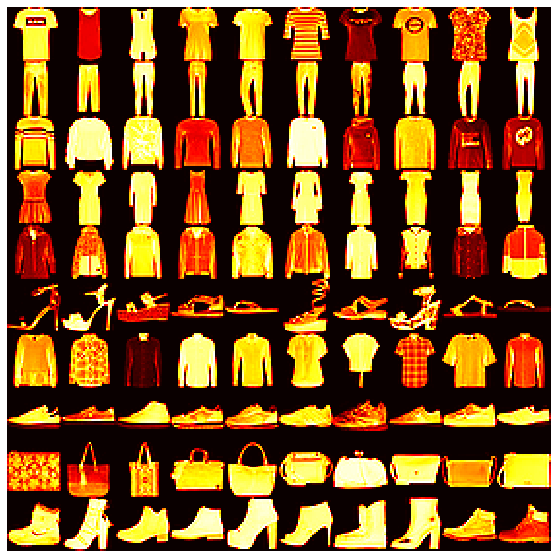

In [0]:
categories = [
    X_train[y_train == i]
    for i in range(10)
]

ten_of_each = np.array([c[:10] for c in categories])
ten_of_each = np.transpose(ten_of_each, (0, 2, 1, 3)).reshape(280, 280)

plt.figure(figsize=(10, 10))
plt.imshow(ten_of_each, cmap='hot')
plt.axis('off');

### Input preprocessing

So far our data is held as numpy arrays of unsigned byte type, i.e. it lies within a range from 0 to 255. Also, the shape of our input is 3-dimensional (num_images, height, width), while our `model` takes 2-dimensional "arrays of 1-dimensional images" (num_images, height * width).

We have to convert that to `torch` tensors and reshape the input. Also, it's a good idea to normalize your image data to lie within a $[0, 1]$ interval. Let's write a function that does all these things:

In [0]:
# Write a function to convert X and y to torch tensors while
# rescaling X to fit into [0, 1] interval and reshaping it properly

# Hint: make sure your input tensor dtype is same as the
# parameters of the model (should be torch.float)

def preprocess_data(X, y):
  X_preprocessed = torch.reshape(torch.from_numpy(X/ 255.).type(torch.float32), (-1, 784))
  y_preprocessed = torch.from_numpy(y)
  return X_preprocessed, y_preprocessed

### Some utilities

In [0]:
# Batch generator
# (here's a very brief description of what python generators are:
# https://stackoverflow.com/a/231855/3801744)
def get_batches(X, y, batch_size, shuffle=False):
  if shuffle:
    shuffle_ids = np.random.permutation(len(X))
    X = X[shuffle_ids].copy()
    y = y[shuffle_ids].copy()
  for i_picture in range(0, len(X), batch_size):
    # Get batch and preprocess it:
    batch_X = X[i_picture:i_picture + batch_size]
    batch_y = y[i_picture:i_picture + batch_size]
    
    # 'return' the batch (see the link above to
    # better understand what 'yield' does)
    yield preprocess_data(batch_X, batch_y)

In [0]:
def get_test_predictions(model, batch_size=100):
  predictions_test = np.concatenate([
    model(batch_X).to('cpu').detach().numpy()
    for batch_X, batch_y in get_batches(X_test, y_test, batch_size)
  ], axis=0)
  return np.argmax(predictions_test, axis=1)


## Main training loop


In [0]:
def train_and_log(experiment, *args, **kwargs):
  experiment.log_parameters(kwargs)
  
  accuracy, loss = train_model(*args, **kwargs)

  experiment.log_metrics({'accuracy': accuracy, 'loss': loss})
  return accuracy

In [0]:
def train_model(n_epochs, batch_size=100, learning_rate=0.001, hidden_size=100):
  # Defining the model
  input_size = 28 * 28 # number of pixels per image
  output_size = 10 # number of classes

  model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ELU(),
    torch.nn.Linear(hidden_size, output_size),
  )

  # Defining the loss function:
  loss_function = torch.nn.CrossEntropyLoss()

  # Setting up the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train / eval loop
  for i_epoch in range(n_epochs):
    for batch_X, batch_y in get_batches(X_train, y_train,
                                        batch_size=batch_size,
                                        shuffle=True):

      # Compute the loss, zero the gradients, and make an optimization step
      predictions = model(batch_X) # compute the predictions
      loss = loss_function(predictions, batch_y) # compute the loss

      model.zero_grad() # zero the gradients
      loss.backward() # compute new gradients
      optimizer.step() # do an optimization step

    for batch_X, batch_y in get_batches(X_test, y_test,
                                        batch_size=batch_size):

      # Compute the loss
      predictions = model(batch_X) # compute the predictions
      loss = loss_function(predictions, batch_y) # compute the loss
    accuracy = accuracy_score(get_test_predictions(model), y_test)

  return accuracy, loss.item()

In [0]:
from getpass import getpass
api_key = getpass("Key: ")

Key: ··········


In [0]:
experiment = Experiment(api_key=api_key, project_name="comet FMNIST", workspace="anaderi-demo")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/anaderi-demo/comet-fmnist/cd635f97f7e641e98600074d0f217f4b



In [0]:
n_epochs = 6
learning_rate = 0.0005
hidden_size = 150

score = train_and_log(experiment, n_epochs=n_epochs, learning_rate=learning_rate, 
                      hidden_size=hidden_size)
print ("Score: {}".format(score))
experiment.end()


Score: 0.8626


## Let's examine how it looks at comet.ml

In [0]:
experiment.display()

## Comet.ml logging capabilities

In [0]:
print ("\n".join([s for s in experiment.__dir__() if  s.startswith("log_")]))


log_code
log_graph
log_env_details
log_git_metadata
log_git_patch
log_env_gpu
log_env_cpu
log_env_host
log_other
log_others
log_dependency
log_system_info
log_html
log_html_url
log_epoch_end
log_metric
log_parameter
log_figure
log_asset_data
log_asset_folder
log_asset
log_audio
log_histogram_3d
log_image
log_current_epoch
log_parameters
log_metrics
log_dataset_info
log_dataset_hash


## Let's see how does the score depend on the number of hidden size parameter

In [0]:
for hidden_size in [50, 150, 200]:
  experiment = Experiment(api_key=api_key, project_name="comet FMNIST")
  score = train_and_log(experiment, n_epochs=n_epochs, learning_rate=learning_rate, 
                      hidden_size=hidden_size)
  experiment.end()


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/anaderi-demo/comet-fmnist/88ef4616caa7465d96cfcf89e5811aca

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/anaderi-demo/comet-fmnist/88ef4616caa7465d96cfcf89e5811aca
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy                 : (0.8541, 0.8541)
COMET INFO:     loss                     : (0.4697524607181549, 0.4697524607181549)
COMET INFO:     sys.cpu.percent.01       : (8.7, 8.7)
COMET INFO:     sys.cpu.percent.02       : (7.8, 7.8)
COMET INFO:     sys.cpu.percent.avg      : (8.25, 8.25)
COMET INFO:     sys.gpu.0.free_memory    : (11985420288.0, 11985420288.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory    : (11534336.0, 11534336.0)
COMET INFO:     sys.ram.total            : (136552284

### Click on one of the experiment links to explore Comet.ml charting capability

## Homework

1. Save experiments to specific `workspace` (should be created first and have unique name) and share it with your friend
1. Add chart with 3 parallel axes: [`hidden_size`, `accuracy`, `loss`]
1. Sort by `accuracy` first
1. Optimise `learning_rate` and `hiddent_size` via scikit-optimize package
1. (*) Cast more convolutional magic

```
model = torch.nn.Sequential(
            Reshape(-1, 1, 28, 28),
            torch.nn.Conv2d(in_channels=1,
                            out_channels=8,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=8,
                            out_channels=16,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2, padding=1),
            Reshape(-1, 512),
            torch.nn.Linear(512, 10)
        ).to(device)
```

